In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.scDEED as scd
import BacSC.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B_subilis_DNA-damage-30min"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 13862 × 29765
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [5]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/2959
Aggregating feature 200/2959
Aggregating feature 300/2959
Aggregating feature 400/2959
Aggregating feature 500/2959
Aggregating feature 600/2959
Aggregating feature 700/2959
Aggregating feature 800/2959
Aggregating feature 900/2959
Aggregating feature 1000/2959
Aggregating feature 1100/2959
Aggregating feature 1200/2959
Aggregating feature 1300/2959
Aggregating feature 1400/2959
Aggregating feature 1500/2959
Aggregating feature 1600/2959
Aggregating feature 1700/2959
Aggregating feature 1800/2959
Aggregating feature 1900/2959
Aggregating feature 2000/2959
Aggregating feature 2100/2959
Aggregating feature 2200/2959
Aggregating feature 2300/2959
Aggregating feature 2400/2959
Aggregating feature 2500/2959
Aggregating feature 2600/2959
Aggregating feature 2700/2959
Aggregating feature 2800/2959
Aggregating feature 2900/2959


AnnData object with n_obs × n_vars = 13862 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.975
Zero inflation of aggregated data: 0.86


### Filter cells

--> filter based on mean absolute standard deviation

In [7]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2, min_genes=100)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    13801
True        61
Name: outlier, dtype: int64
Total number of cells: 13862
Number of cells after filtering: 13801


AnnData object with n_obs × n_vars = 13801 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

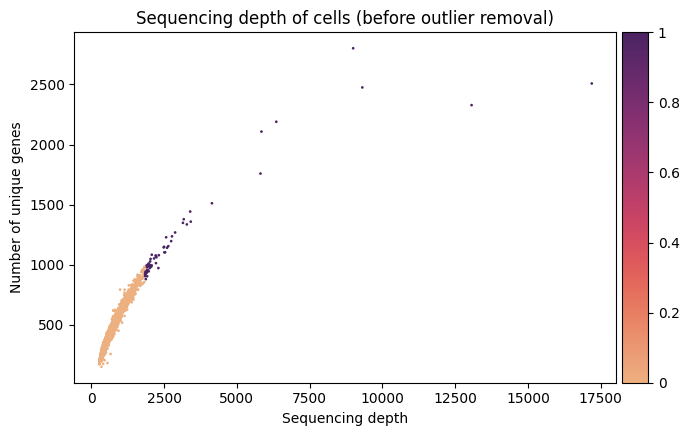

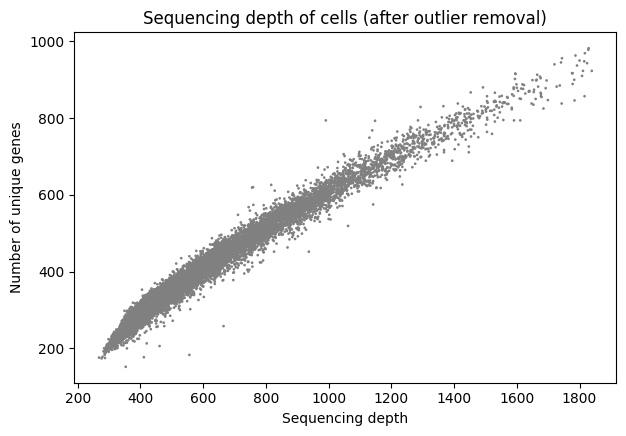

In [8]:
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [9]:
data_gene.layers["counts"] = data_gene.X.copy()

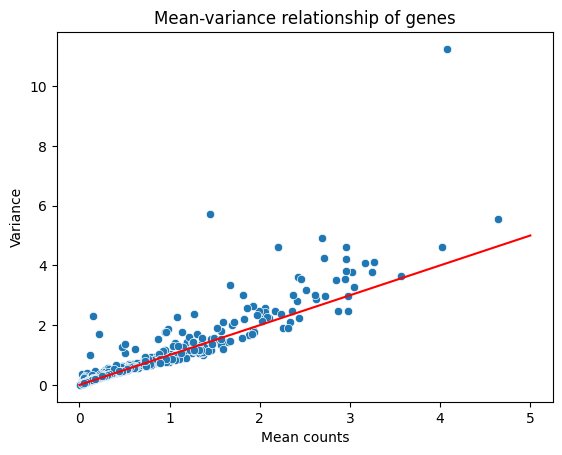

In [10]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [11]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [12]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [13]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
Sr1   Gene Expression   PA01                125     0.010362   
aadK  Gene Expression   PA01                777     0.063039   
aag   Gene Expression   PA01                157     0.013043   
aapA  Gene Expression   PA01                514     0.042751   
abbA  Gene Expression   PA01               2022     0.176871   
...               ...    ...                ...          ...   
znuB  Gene Expression   PA01                816     0.069778   
znuC  Gene Expression   PA01                330     0.027752   
zosA  Gene Expression   PA01                409     0.034490   
zur   Gene Expression   PA01                660     0.055431   
zwf   Gene Expression   PA01               4854     0.440910   

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
Sr1            0.010308              99.094269         143.0   
aadK           0.061132              94.369973         870.0   
aag            0.012958              98.862401         180.0   
aapA           0.041862              96.275632         590.0   
abbA           0.162859              85.348888        2441.0   
...                 ...                    ...           ...   
znuB           0.067451              94.087385         963.0   
znuC           0.027374              97.608869         383.0   
zosA           0.033909              97.036447         476.0   
zur            0.053949              95.217738         765.0   
zwf            0.365275              64.828636        6085.0   

      log1p_total_counts  n_cells  var_counts  is_scd_outlier  nb_overdisp  \
Sr1             4.969813      125    0.013008           False     0.037399   
aadK            6.769642      777    0.073702           False     0.263461   
aag             5.198497      157    0.016350           False     0.047885   
aapA            6.381816      514    0.052806           False     0.161034   
abbA            7.800573     2022    0.216597           False     1.110872   
...                  ...      ...         ...             ...          ...   
znuB            6.871091      816    0.089400           False     0.291618   
znuC            5.950643      330    0.036256           False     0.098512   
zosA            6.167516      409    0.044314           False     0.124461   
zur             6.641182      660    0.069313           False     0.220121   
zwf             8.713746     4854    0.457508           False     8.476926   

      nb_overdisp_cutoff    nb_mean    nb_umi  Intercept_step1_sct  \
Sr1             0.037399 -10.994738  2.301592           -11.970694   
aadK            0.263461  -9.802312  2.524820                  NaN   
aag             0.047885 -10.829252  2.324395           -12.378568   
aapA            0.161034  -9.709121  2.350325            -9.070901   
abbA            1.110872  -9.118506  2.639994            -9.310758   
...                  ...        ...       ...                  ...   
znuB            0.291618  -9.824355  2.560828            -9.717345   
znuC            0.098512 -10.061081  2.319039           -12.453809   
zosA            0.124461  -9.842875  2.319262                  NaN   
zur             0.220121  -9.743176  2.452993           -11.832070   
zwf             8.476926  -7.691930  2.461583            -7.886686   

      log_umi_step1_sct  dispersion_step1_sct  
Sr1            2.646557              0.065160  
aadK                NaN                   NaN  
aag            2.871683              0.062719  
aapA           2.121533              0.061561  
abbA           2.709199              0.046609  
...                 ...                   ...  
znuB           2.524209              0.066869  
znuC           3.163941              0.063700  
zosA                NaN                   NaN  
zur            3.188577              0.054610  
zwf            2.528761              0.012274  

[2959 rows x 18 columns]

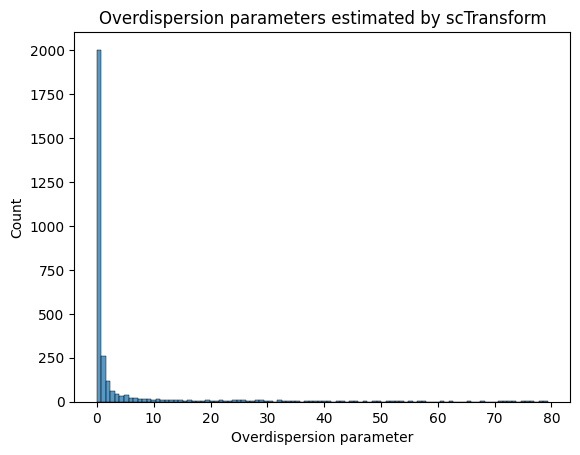

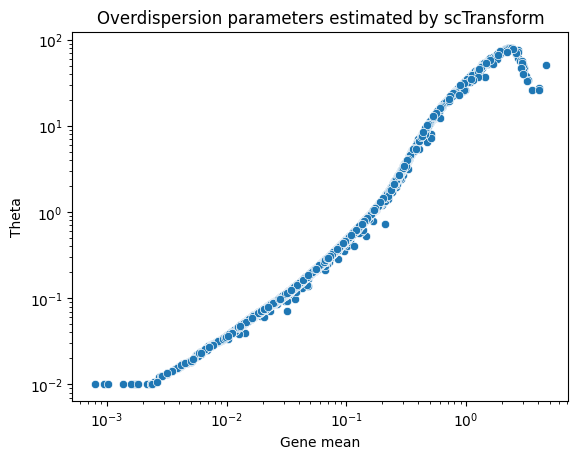

In [14]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [15]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [16]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

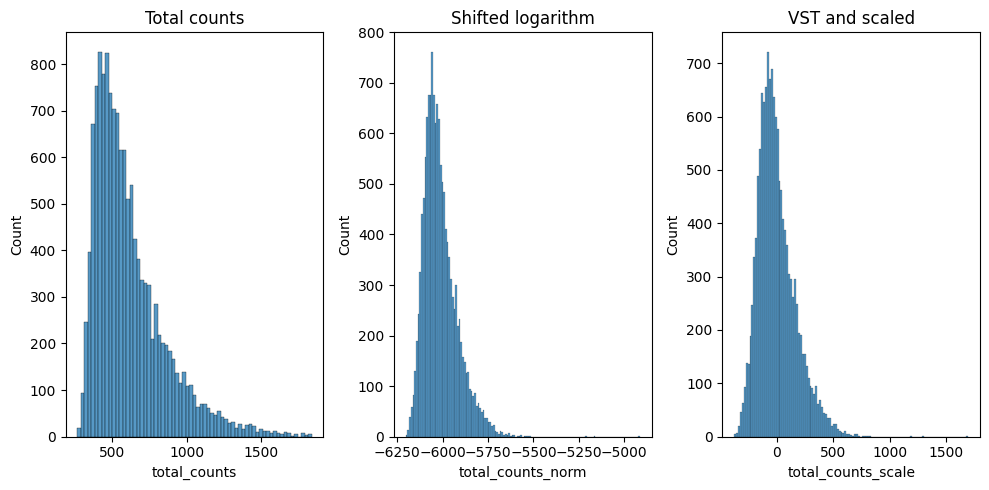

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [18]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 13801 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [19]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

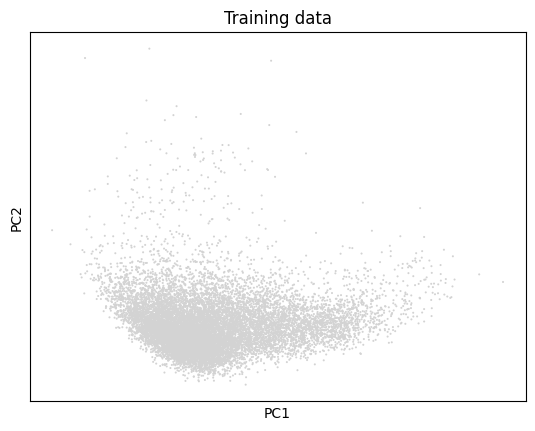

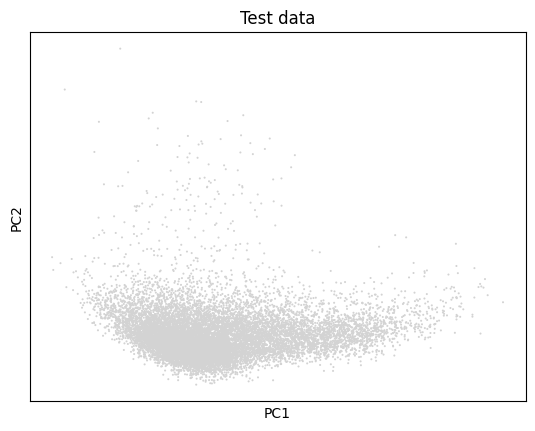

In [20]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [21]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:8


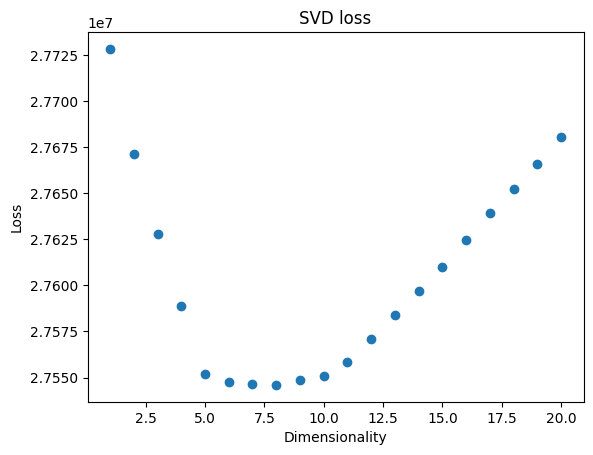

In [22]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

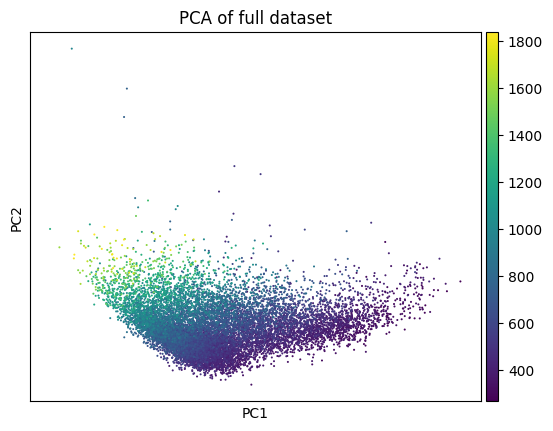

In [23]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [24]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [25]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

41


In [28]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="Bsub_damage_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 150
Optimal min_dist: 0.3


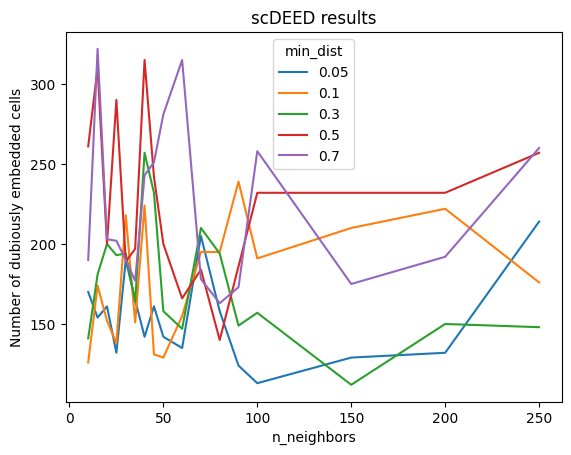

In [29]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [30]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


In [31]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [32]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


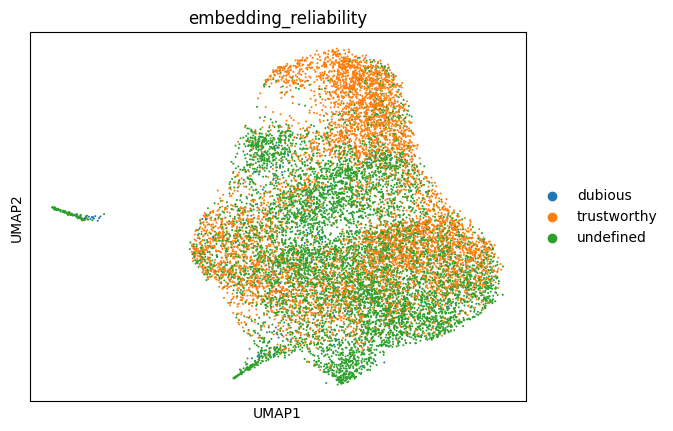

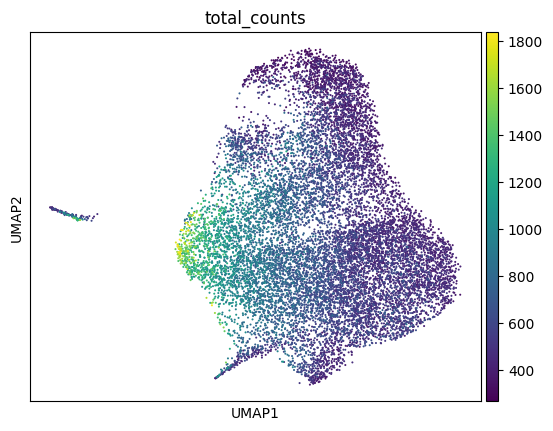

In [33]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [34]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [35]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

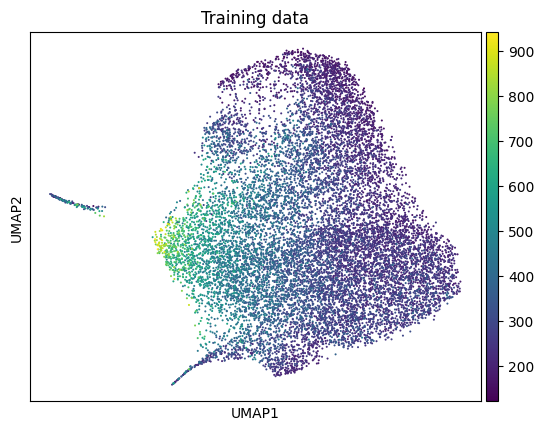

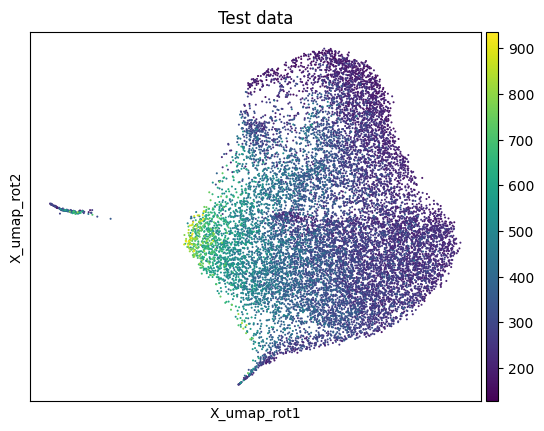

In [36]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [37]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)

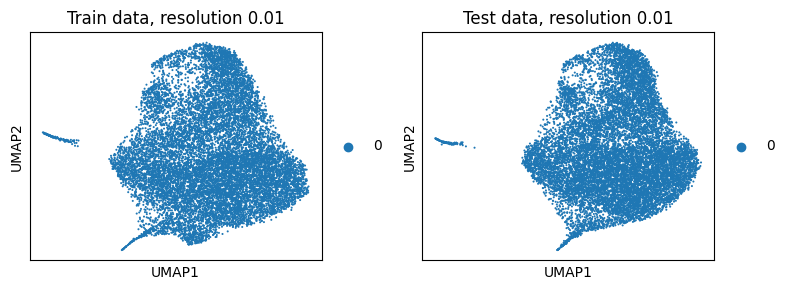

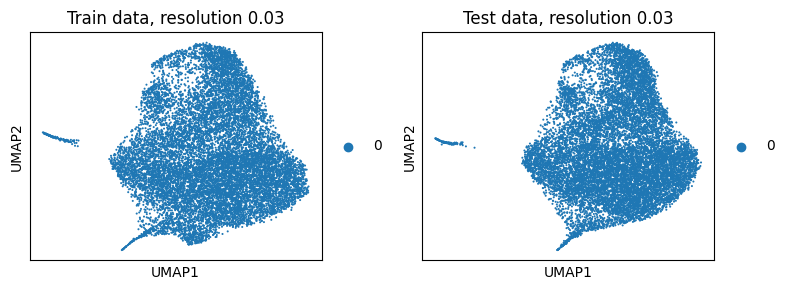

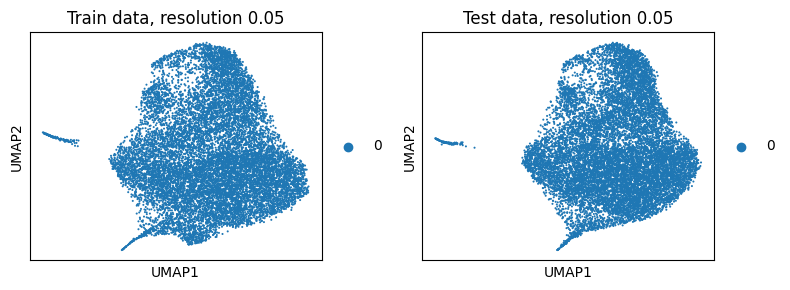

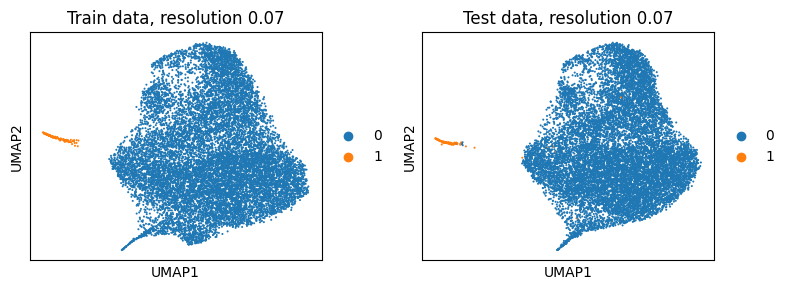

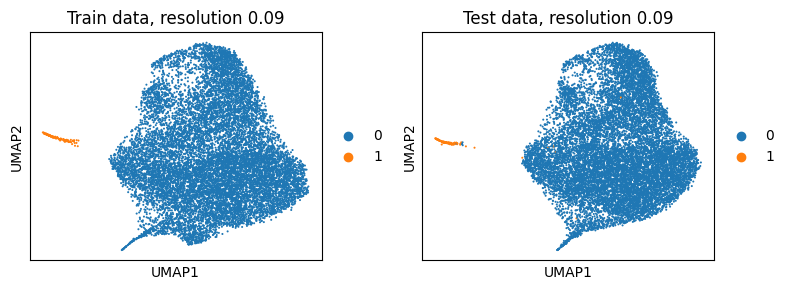

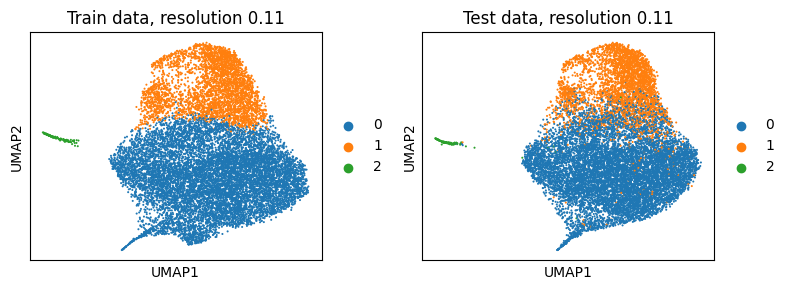

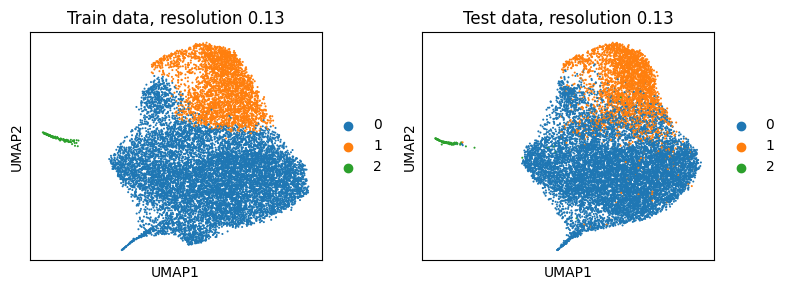

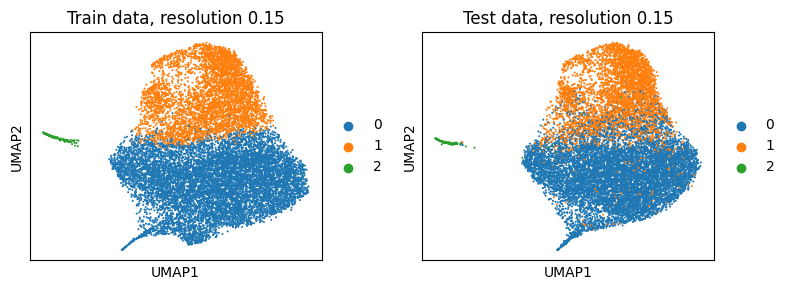

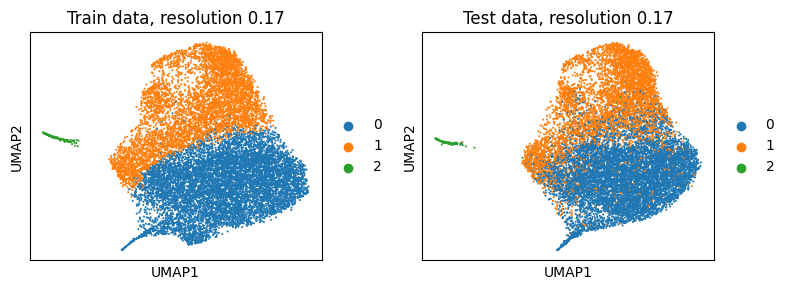

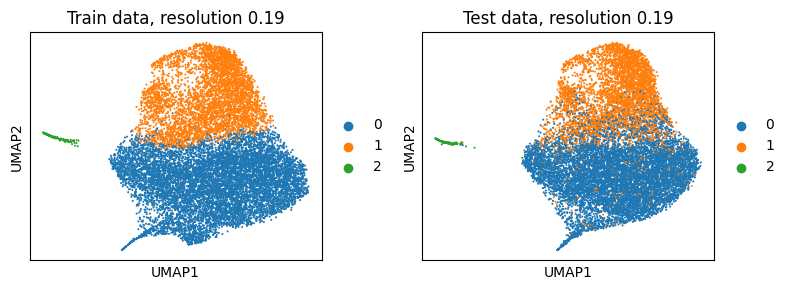

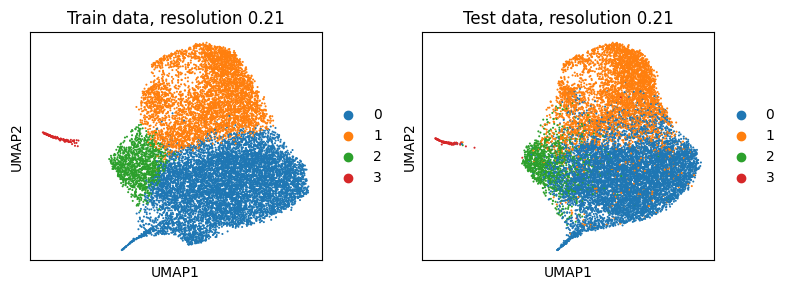

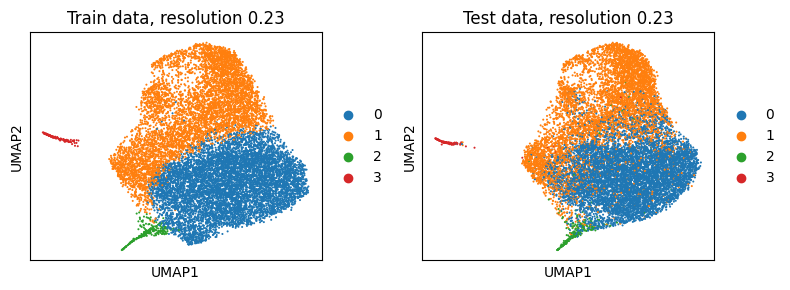

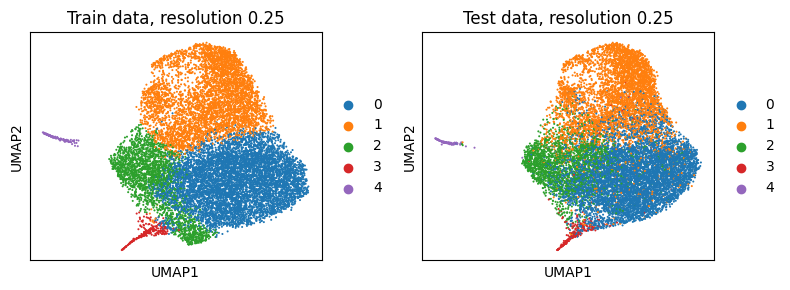

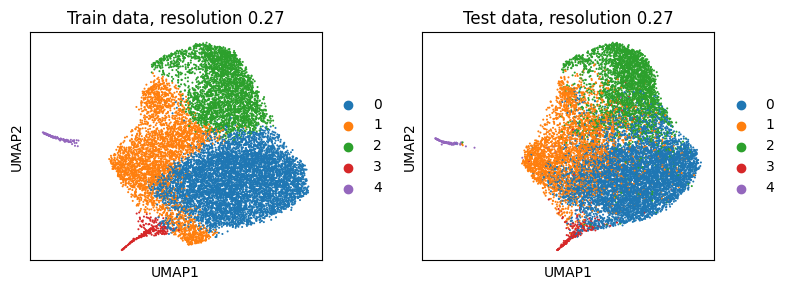

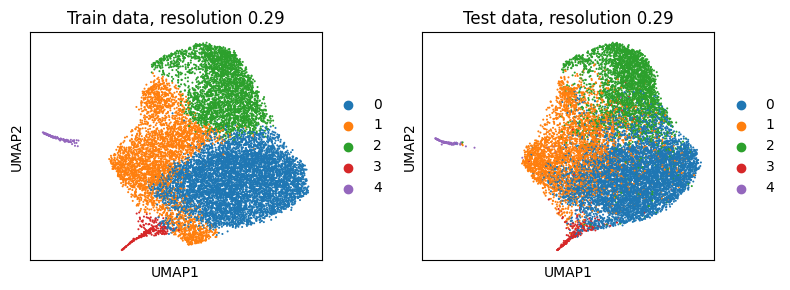

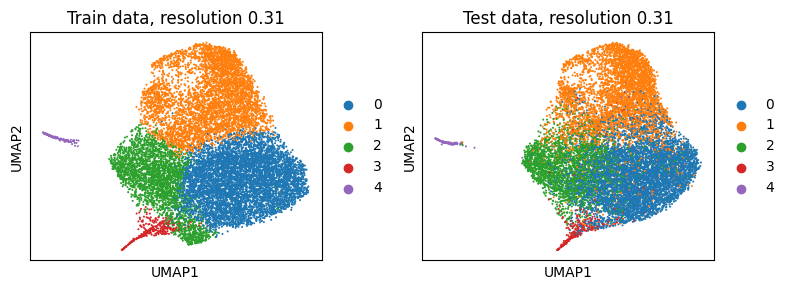

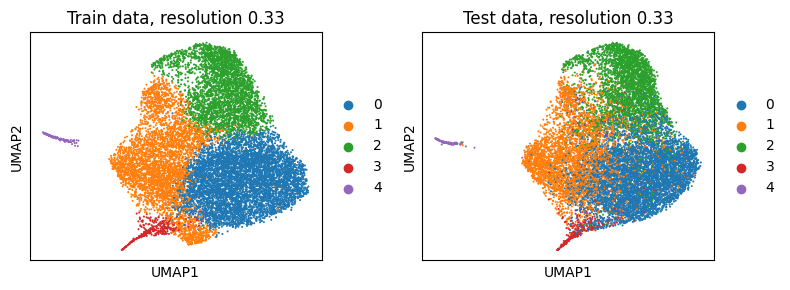

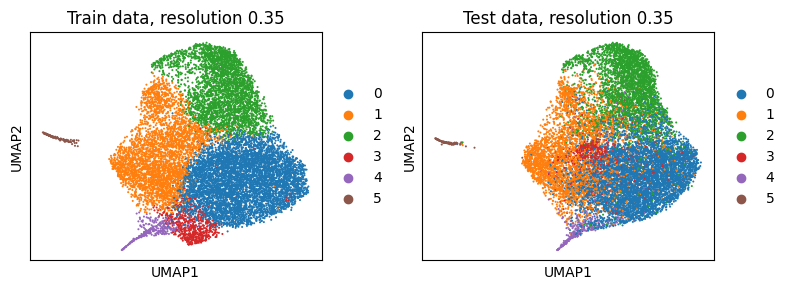

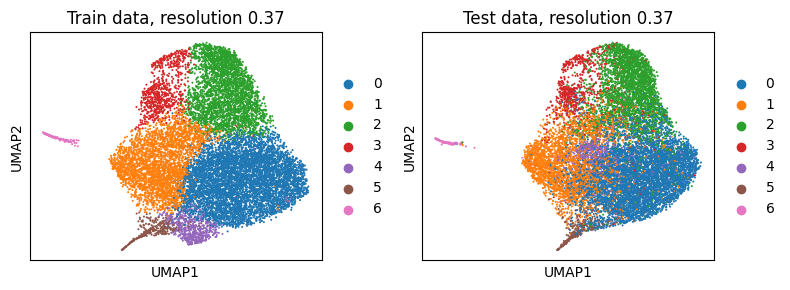

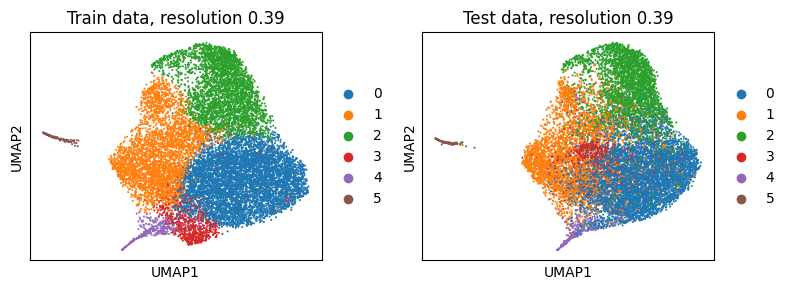

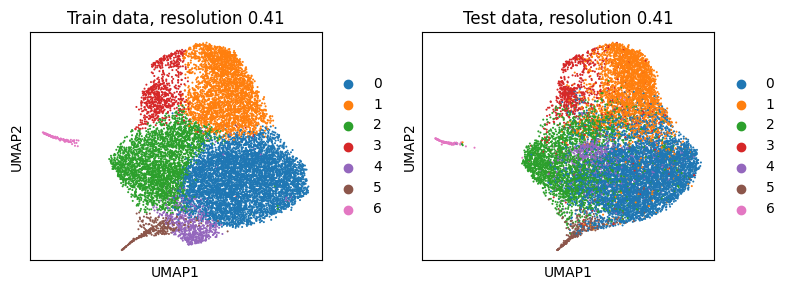

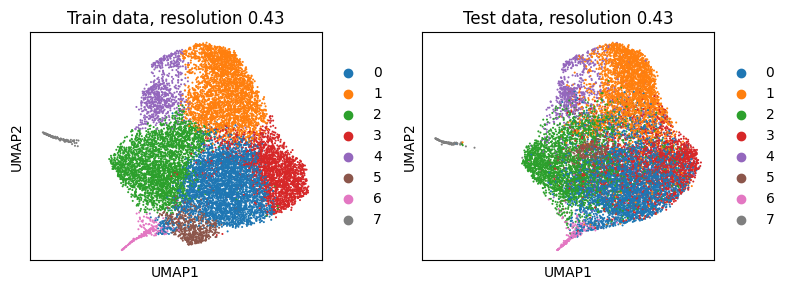

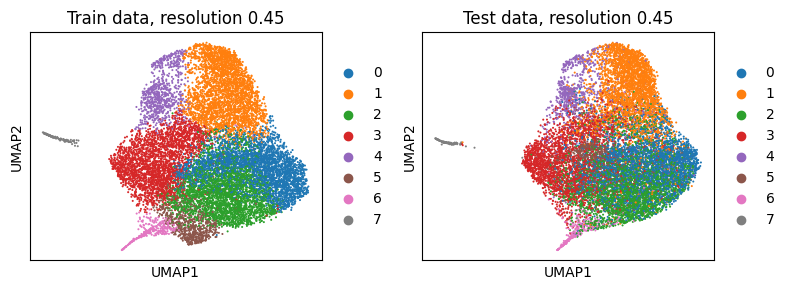

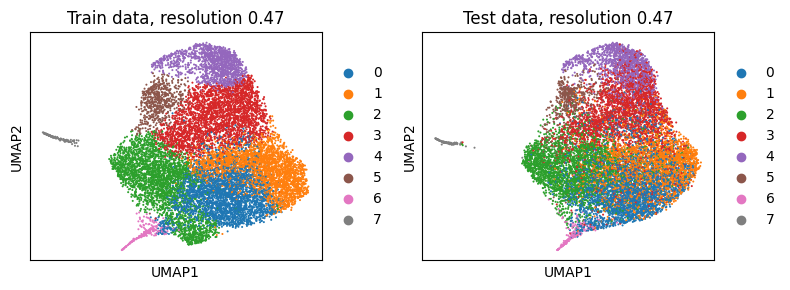

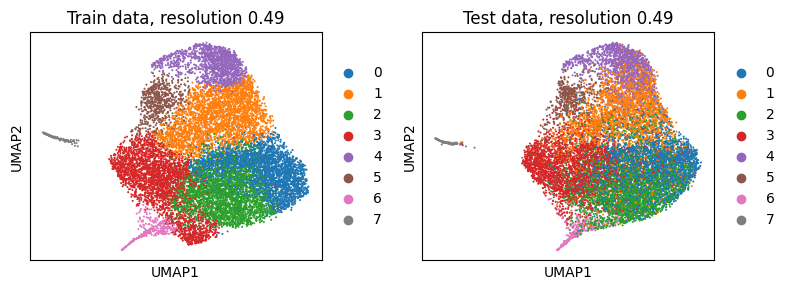

In [38]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [39]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 1 - Train: 0.45 - Test: 0.45 - Random: 0.45
resolution: 0.07 - clusters: 2 - Train: 0.429 - Test: 0.429 - Random: 0.422
resolution: 0.09 - clusters: 2 - Train: 0.409 - Test: 0.409 - Random: 0.402
resolution: 0.11 - clusters: 3 - Train: 0.404 - Test: 0.38 - Random: 0.238
resolution: 0.13 - clusters: 3 - Train: 0.389 - Test: 0.367 - Random: 0.236
resolution: 0.15 - clusters: 3 - Train: 0.38 - Test: 0.353 - Random: 0.195
resolution: 0.17 - clusters: 3 - Train: 0.369 - Test: 0.333 - Random: 0.17
resolution: 0.19 - clusters: 3 - Train: 0.358 - Test: 0.329 - Random: 0.17
resolution: 0.21 - clusters: 4 - Train: 0.352 - Test: 0.31 - Random: 0.13
resolution: 0.23 - clusters: 4 - Train: 0.339 - Test: 0.297 - Random: 0.13
resolution: 0.25 - clusters: 5 - Train: 0.339 - Test: 0.285 - Random: 0.093
resolution: 0.27 - clusters:

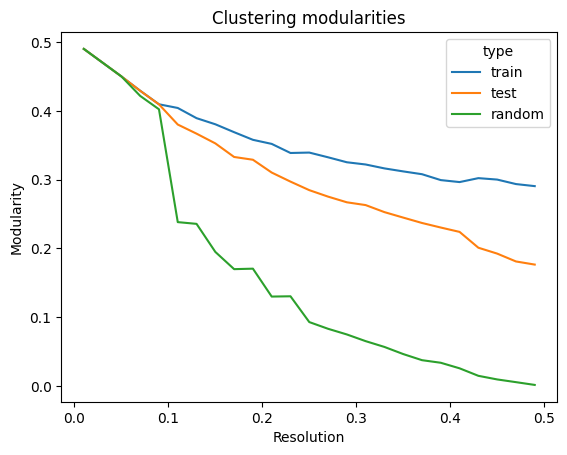

In [40]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

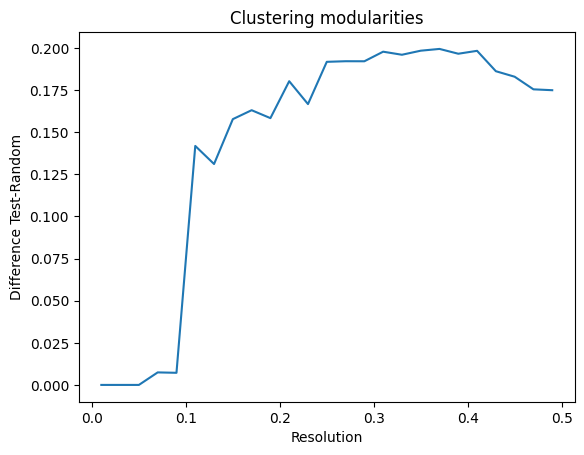

In [41]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [42]:
result_path = "Bsub_damage_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [43]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

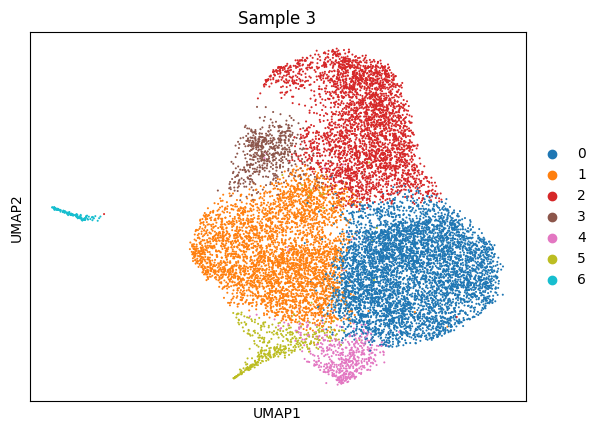

In [44]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [45]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

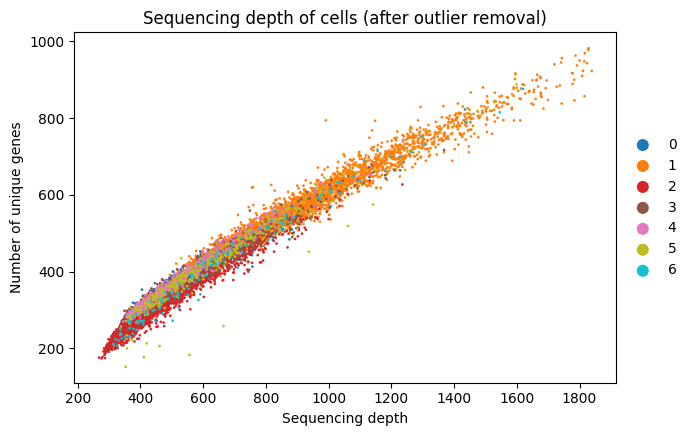

In [46]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

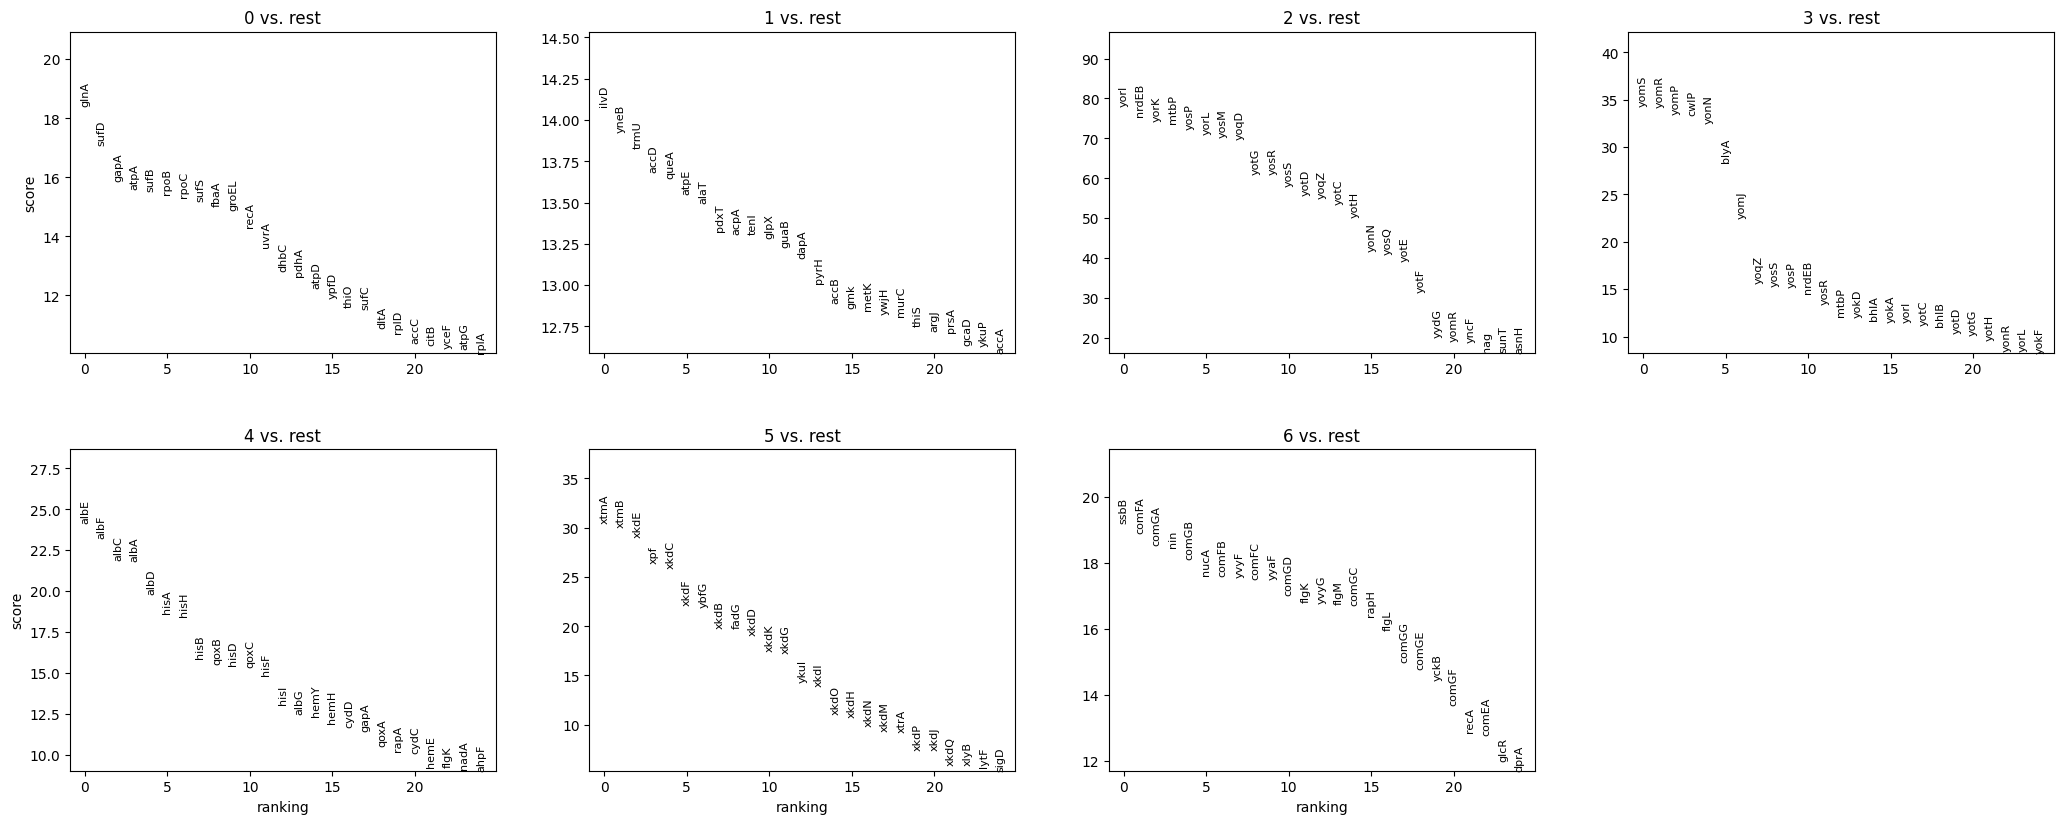

In [47]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

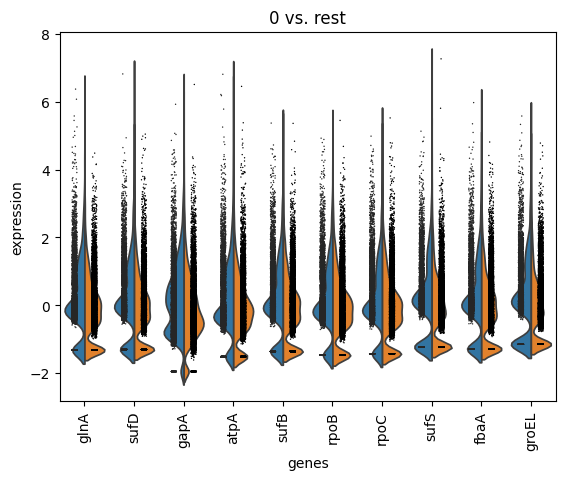

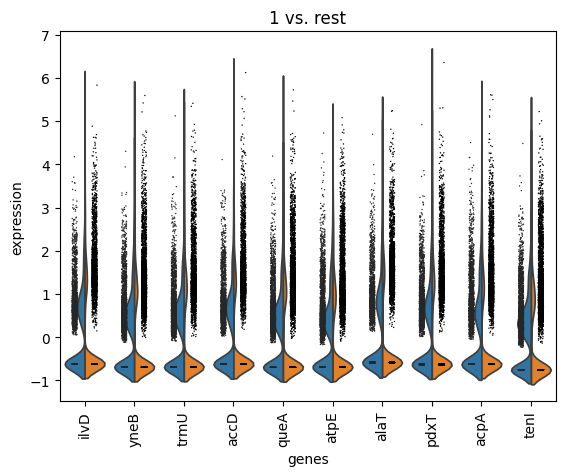

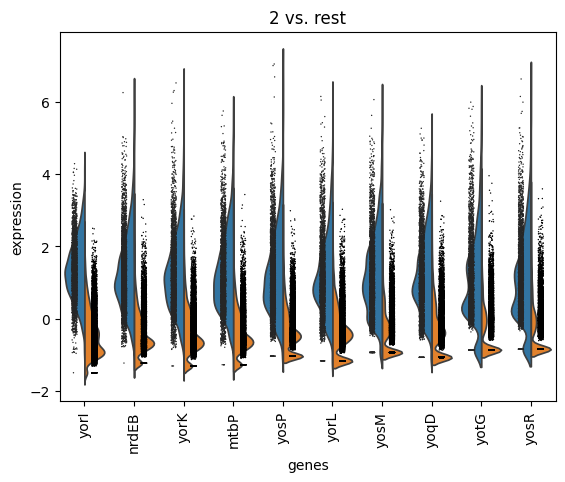

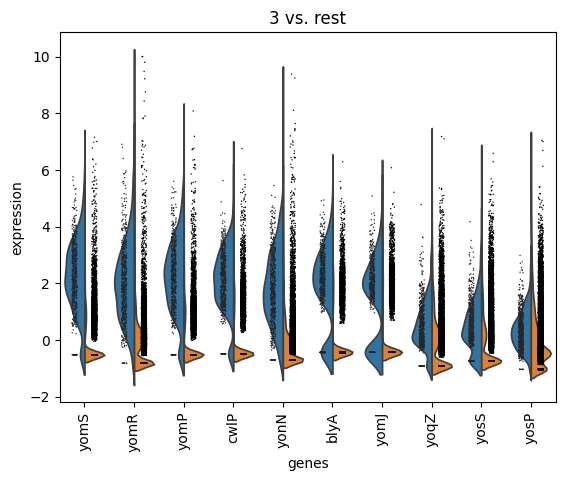

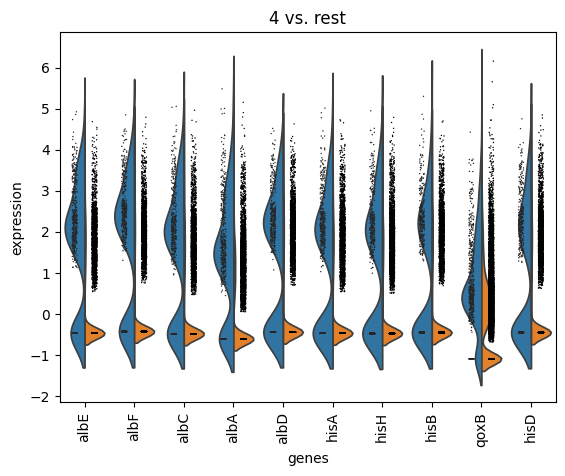

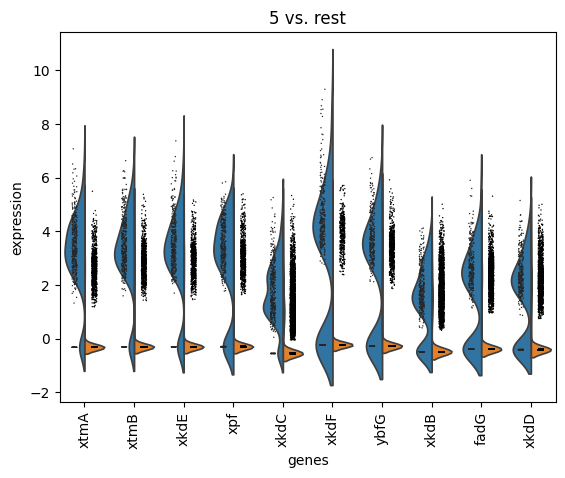

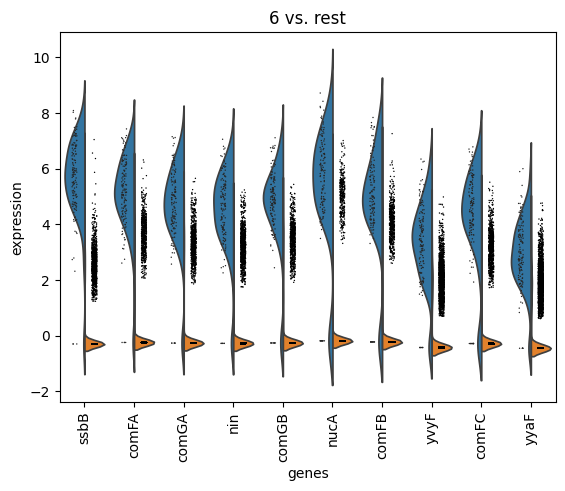

In [48]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

## Attach feature table

In [49]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B_subilis_DNA-damage-30min"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 13801 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [50]:
feature_table = pd.read_csv("../../data/probe_Bac_scRNAseq_Rosenthal/B_subtilis_168_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]

feature_table

Locus tag Protein accession  \
0     BSU_00010       NP_387882.1   
1     BSU_00020       NP_387883.1   
2     BSU_00030       NP_387884.1   
3     BSU_00040       NP_387885.1   
4     BSU_00050       NP_387886.2   
...         ...               ...   
4531  BSU_41020       NP_391982.1   
4532  BSU_41030       NP_391983.1   
4533  BSU_41040       NP_391984.1   
4534  BSU_41050       NP_391985.1   
4535  BSU_41060       NP_391986.1   

                                                   Name Symbol  
0     chromosomal replication initiator informationa...   dnaA  
1                     DNA polymerase III (beta subunit)   dnaN  
2     RNA binding protein involved in ribosome matur...   rlbA  
3     RecA filament-DNA complex stabilisation, ssDNA...   recF  
4           regulator of extracellular matrix formation   remB  
...                                                 ...    ...  
4531  tRNA modification GTPase and tRNA-U34 5-formyl...   mnmE  
4532       SpoIIIJ-associated RNA/ssDNA-binding protein    jag  
4533  Sec-independent factor for membrane protein in...  oxaAA  
4534  protein component of ribonuclease P (RNase P) ...   rnpA  
4535                              ribosomal protein L34   rpmH  

[4536 rows x 4 columns]

In [51]:
df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Symbol').drop_duplicates("index").set_index("index")
data_gene.var = df3

In [52]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
index                                                           
Sr1    Gene Expression   PA01                125     0.010362   
aadK   Gene Expression   PA01                777     0.063039   
aag    Gene Expression   PA01                157     0.013043   
aapA   Gene Expression   PA01                514     0.042751   
abbA   Gene Expression   PA01               2022     0.176871   
...                ...    ...                ...          ...   
znuB   Gene Expression   PA01                816     0.069778   
znuC   Gene Expression   PA01                330     0.027752   
zosA   Gene Expression   PA01                409     0.034490   
zur    Gene Expression   PA01                660     0.055431   
zwf    Gene Expression   PA01               4854     0.440910   

       log1p_mean_counts  pct_dropout_by_counts  total_counts  \
index                                                           
Sr1             0.010308              99.094269         143.0   
aadK            0.061132              94.369973         870.0   
aag             0.012958              98.862401         180.0   
aapA            0.041862              96.275632         590.0   
abbA            0.162859              85.348888        2441.0   
...                  ...                    ...           ...   
znuB            0.067451              94.087385         963.0   
znuC            0.027374              97.608869         383.0   
zosA            0.033909              97.036447         476.0   
zur             0.053949              95.217738         765.0   
zwf             0.365275              64.828636        6085.0   

       log1p_total_counts  n_cells  var_counts  ...    nb_umi  \
index                                           ...             
Sr1              4.969813      125    0.013008  ...  2.301592   
aadK             6.769642      777    0.073702  ...  2.524820   
aag              5.198497      157    0.016350  ...  2.324395   
aapA             6.381816      514    0.052806  ...  2.350325   
abbA             7.800573     2022    0.216597  ...  2.639994   
...                   ...      ...         ...  ...       ...   
znuB             6.871091      816    0.089400  ...  2.560828   
znuC             5.950643      330    0.036256  ...  2.319039   
zosA             6.167516      409    0.044314  ...  2.319262   
zur              6.641182      660    0.069313  ...  2.452993   
zwf              8.713746     4854    0.457508  ...  2.461583   

       Intercept_step1_sct  log_umi_step1_sct  dispersion_step1_sct      mean  \
index                                                                           
Sr1             -11.970694           2.646557              0.065160 -4.630818   
aadK                   NaN                NaN                   NaN -2.567001   
aag             -12.378568           2.871683              0.062719 -4.376103   
aapA             -9.070901           2.121533              0.061561 -3.093332   
abbA             -9.310758           2.709199              0.046609 -1.061391   
...                    ...                ...                   ...       ...   
znuB             -9.717345           2.524209              0.066869 -2.462748   
znuC            -12.453809           3.163941              0.063700 -3.617900   
zosA                   NaN                NaN                   NaN -3.368064   
zur             -11.832070           3.188577              0.054610 -2.763603   
zwf              -7.886686           2.528761              0.012274  0.893756   

            std  Locus tag  Protein accession  \
index                                           
Sr1    0.436977        NaN                NaN   
aadK   0.633907  BSU_26790        NP_390556.1   
aag    0.460859  BSU_38620        NP_391741.1   
aapA   0.611386  BSU_27090        NP_390587.2   
abbA   0.547990  BSU_14120        NP_389295.1   
...         ...        ...                ...   
znuB   0.629896  BSU_0287

In [53]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")